In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from transformers import ViTForImageClassification, ViTFeatureExtractor
from tqdm import tqdm
import pandas as pd
import os
from datasets import DatasetDict, Dataset
from transformers import AutoImageProcessor
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from transformers import SwinForImageClassification, AutoImageProcessor  # Updated import

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import pandas as pd
import os
from torchvision import models

In [2]:
# Define the paths to your training and testing datasets
train_data_dir = "C:/Users/Amir/Desktop/skin cancer paper/skin cancer isic/Skin Cancer ISIC/Skin cancer ISIC The International Skin Imaging Collaboration/train"  # Replace with the path to your training dataset
test_data_dir = "C:/Users/Amir/Desktop/skin cancer paper/skin cancer isic/Skin Cancer ISIC/Skin cancer ISIC The International Skin Imaging Collaboration/test"  # Replace with the path to your testing dataset

In [3]:
# Corrected imports
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from transformers import SwinForImageClassification, AutoImageProcessor

# Modified Augmentations for ResNet
resnet_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])




# ImageFolder applies `transform` to each image
train_dataset = datasets.ImageFolder(train_data_dir, transform=resnet_transform)
test_dataset = datasets.ImageFolder(test_data_dir, transform=resnet_transform)

# Split training data into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Check classes (ensure consistency)
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

# Print dataset sizes
print(f"Train size: {len(train_subset)}")
print(f"Val size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")


Number of classes: 9
Train size: 1791
Val size: 448
Test size: 118


In [6]:
# MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# Modify final layer
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, num_classes))

C:\Users\Amir\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Amir\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\Amir/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:03<00:00, 3.84MB/s]


In [7]:
# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [8]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

# Lists to store loss and accuracy for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
num_epochs = 100
csv_filename = "mobilenet_training_metrics.csv"
metrics_df = pd.DataFrame(columns=["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])
metrics_df.to_csv(csv_filename, index=False)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    
    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training")
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        
        train_loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)  # Store for plotting
    train_accuracies.append(train_acc)  # Store for plotting

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct, total = 0, 0
    
    val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation")
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            val_loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)
    
    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)  # Store for plotting
    val_accuracies.append(val_acc)  # Store for plotting

    scheduler.step(val_loss)
    
    # Save metrics
    epoch_df = pd.DataFrame([[epoch+1, train_loss, train_acc, val_loss, val_acc]],
                           columns=["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])
    epoch_df.to_csv(csv_filename, mode='a', header=False, index=False)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")


Epoch [1/100] Validation: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s, accuracy=64.3, loss=0.922]


Epoch 1/100
Train Loss: 1.4312 | Train Acc: 51.87%
Val Loss: 1.0316 | Val Acc: 64.29%


Epoch [2/100] Validation: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s, accuracy=67.2, loss=0.959]


Epoch 2/100
Train Loss: 0.8467 | Train Acc: 71.97%
Val Loss: 0.9150 | Val Acc: 67.19%


Epoch [3/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.27it/s, accuracy=70.1, loss=0.841]


Epoch 3/100
Train Loss: 0.6873 | Train Acc: 76.83%
Val Loss: 0.8296 | Val Acc: 70.09%


Epoch [4/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s, accuracy=69.4, loss=0.669]


Epoch 4/100
Train Loss: 0.5521 | Train Acc: 80.46%
Val Loss: 0.7820 | Val Acc: 69.42%


Epoch [5/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s, accuracy=69.9, loss=0.883]


Epoch 5/100
Train Loss: 0.4571 | Train Acc: 84.09%
Val Loss: 0.8155 | Val Acc: 69.87%


Epoch [6/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s, accuracy=71.9, loss=0.705]


Epoch 6/100
Train Loss: 0.3913 | Train Acc: 85.76%
Val Loss: 0.8020 | Val Acc: 71.88%


Epoch [7/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=70.3, loss=0.787]


Epoch 7/100
Train Loss: 0.3275 | Train Acc: 88.05%
Val Loss: 0.8443 | Val Acc: 70.31%


Epoch [8/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=71.2, loss=0.794]


Epoch 8/100
Train Loss: 0.2942 | Train Acc: 89.34%
Val Loss: 0.7996 | Val Acc: 71.21%


Epoch [9/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=72.1, loss=0.718]


Epoch 9/100
Train Loss: 0.2311 | Train Acc: 91.29%
Val Loss: 0.7756 | Val Acc: 72.10%


Epoch [10/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=72.5, loss=0.664]


Epoch 10/100
Train Loss: 0.2065 | Train Acc: 91.90%
Val Loss: 0.7721 | Val Acc: 72.54%


Epoch [11/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s, accuracy=72.8, loss=0.647]


Epoch 11/100
Train Loss: 0.2126 | Train Acc: 92.07%
Val Loss: 0.7632 | Val Acc: 72.77%


Epoch [12/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s, accuracy=70.8, loss=0.651]


Epoch 12/100
Train Loss: 0.1902 | Train Acc: 93.47%
Val Loss: 0.7812 | Val Acc: 70.76%


Epoch [13/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s, accuracy=71.9, loss=0.66] 


Epoch 13/100
Train Loss: 0.1743 | Train Acc: 93.47%
Val Loss: 0.7934 | Val Acc: 71.88%


Epoch [14/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s, accuracy=71.9, loss=0.668]


Epoch 14/100
Train Loss: 0.1813 | Train Acc: 92.85%
Val Loss: 0.7622 | Val Acc: 71.88%


Epoch [15/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s, accuracy=72.5, loss=0.61] 


Epoch 15/100
Train Loss: 0.1697 | Train Acc: 93.41%
Val Loss: 0.7727 | Val Acc: 72.54%


Epoch [16/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s, accuracy=71.2, loss=0.714]


Epoch 16/100
Train Loss: 0.1752 | Train Acc: 93.52%
Val Loss: 0.7741 | Val Acc: 71.21%


Epoch [17/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s, accuracy=72.8, loss=0.721]


Epoch 17/100
Train Loss: 0.1603 | Train Acc: 94.19%
Val Loss: 0.7791 | Val Acc: 72.77%


Epoch [18/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s, accuracy=74.1, loss=0.639]


Epoch 18/100
Train Loss: 0.1531 | Train Acc: 94.19%
Val Loss: 0.7473 | Val Acc: 74.11%


Epoch [19/100] Validation: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s, accuracy=72.5, loss=0.715]


Epoch 19/100
Train Loss: 0.1709 | Train Acc: 92.85%
Val Loss: 0.7685 | Val Acc: 72.54%


Epoch [20/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s, accuracy=70.1, loss=0.62] 


Epoch 20/100
Train Loss: 0.1552 | Train Acc: 94.25%
Val Loss: 0.7899 | Val Acc: 70.09%


Epoch [21/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s, accuracy=70.3, loss=0.741]


Epoch 21/100
Train Loss: 0.1517 | Train Acc: 94.36%
Val Loss: 0.8168 | Val Acc: 70.31%


Epoch [22/100] Validation: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s, accuracy=71.4, loss=0.69] 


Epoch 22/100
Train Loss: 0.1592 | Train Acc: 93.52%
Val Loss: 0.8207 | Val Acc: 71.43%


Epoch [23/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s, accuracy=71.9, loss=0.868]


Epoch 23/100
Train Loss: 0.1538 | Train Acc: 93.58%
Val Loss: 0.8270 | Val Acc: 71.88%


Epoch [24/100] Validation: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s, accuracy=70.8, loss=0.755]


Epoch 24/100
Train Loss: 0.1485 | Train Acc: 94.14%
Val Loss: 0.8605 | Val Acc: 70.76%


Epoch [25/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.27it/s, accuracy=71.2, loss=0.763]


Epoch 25/100
Train Loss: 0.1436 | Train Acc: 94.97%
Val Loss: 0.7921 | Val Acc: 71.21%


Epoch [26/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=70.8, loss=0.655]


Epoch 26/100
Train Loss: 0.1442 | Train Acc: 94.30%
Val Loss: 0.8289 | Val Acc: 70.76%


Epoch [27/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s, accuracy=71.2, loss=0.723]


Epoch 27/100
Train Loss: 0.1474 | Train Acc: 94.36%
Val Loss: 0.8177 | Val Acc: 71.21%


Epoch [28/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s, accuracy=71.9, loss=0.621]


Epoch 28/100
Train Loss: 0.1448 | Train Acc: 94.30%
Val Loss: 0.7555 | Val Acc: 71.88%


Epoch [29/100] Validation: 100%|██████████| 14/14 [00:11<00:00,  1.25it/s, accuracy=69, loss=0.778]  


Epoch 29/100
Train Loss: 0.1462 | Train Acc: 94.14%
Val Loss: 0.8052 | Val Acc: 68.97%


Epoch [30/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=72.8, loss=0.696]


Epoch 30/100
Train Loss: 0.1413 | Train Acc: 93.86%
Val Loss: 0.7911 | Val Acc: 72.77%


Epoch [31/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=71.7, loss=0.735]


Epoch 31/100
Train Loss: 0.1468 | Train Acc: 94.08%
Val Loss: 0.8056 | Val Acc: 71.65%


Epoch [32/100] Validation: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s, accuracy=70.8, loss=0.667]


Epoch 32/100
Train Loss: 0.1447 | Train Acc: 94.03%
Val Loss: 0.7992 | Val Acc: 70.76%


Epoch [33/100] Validation: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s, accuracy=69, loss=0.784]  


Epoch 33/100
Train Loss: 0.1504 | Train Acc: 93.86%
Val Loss: 0.7904 | Val Acc: 68.97%


Epoch [34/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s, accuracy=71.2, loss=0.707]


Epoch 34/100
Train Loss: 0.1444 | Train Acc: 94.19%
Val Loss: 0.8154 | Val Acc: 71.21%


Epoch [35/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s, accuracy=72.8, loss=0.604]


Epoch 35/100
Train Loss: 0.1533 | Train Acc: 93.91%
Val Loss: 0.7691 | Val Acc: 72.77%


Epoch [36/100] Validation: 100%|██████████| 14/14 [00:11<00:00,  1.25it/s, accuracy=72.5, loss=0.725]


Epoch 36/100
Train Loss: 0.1427 | Train Acc: 94.42%
Val Loss: 0.7898 | Val Acc: 72.54%


Epoch [37/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s, accuracy=72.1, loss=0.782]


Epoch 37/100
Train Loss: 0.1566 | Train Acc: 93.58%
Val Loss: 0.8150 | Val Acc: 72.10%


Epoch [38/100] Validation: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s, accuracy=69.4, loss=0.735]


Epoch 38/100
Train Loss: 0.1555 | Train Acc: 93.41%
Val Loss: 0.8212 | Val Acc: 69.42%


Epoch [39/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s, accuracy=73.9, loss=0.778]


Epoch 39/100
Train Loss: 0.1520 | Train Acc: 93.36%
Val Loss: 0.7914 | Val Acc: 73.88%


Epoch [40/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.27it/s, accuracy=73.4, loss=0.713]


Epoch 40/100
Train Loss: 0.1442 | Train Acc: 94.30%
Val Loss: 0.7920 | Val Acc: 73.44%


Epoch [41/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s, accuracy=70.3, loss=0.568]


Epoch 41/100
Train Loss: 0.1505 | Train Acc: 93.36%
Val Loss: 0.7992 | Val Acc: 70.31%


Epoch [42/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=71.4, loss=0.727]


Epoch 42/100
Train Loss: 0.1485 | Train Acc: 93.80%
Val Loss: 0.8178 | Val Acc: 71.43%


Epoch [43/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=70.3, loss=0.654]


Epoch 43/100
Train Loss: 0.1467 | Train Acc: 94.08%
Val Loss: 0.7863 | Val Acc: 70.31%


Epoch [44/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=69.2, loss=0.759]


Epoch 44/100
Train Loss: 0.1387 | Train Acc: 94.75%
Val Loss: 0.8458 | Val Acc: 69.20%


Epoch [45/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=68.8, loss=0.76]


Epoch 45/100
Train Loss: 0.1496 | Train Acc: 93.69%
Val Loss: 0.8358 | Val Acc: 68.75%


Epoch [46/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s, accuracy=70.3, loss=0.679]


Epoch 46/100
Train Loss: 0.1539 | Train Acc: 94.53%
Val Loss: 0.8120 | Val Acc: 70.31%


Epoch [47/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s, accuracy=71.7, loss=0.834]


Epoch 47/100
Train Loss: 0.1420 | Train Acc: 94.30%
Val Loss: 0.8272 | Val Acc: 71.65%


Epoch [48/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s, accuracy=71.9, loss=0.788]


Epoch 48/100
Train Loss: 0.1480 | Train Acc: 94.03%
Val Loss: 0.8315 | Val Acc: 71.88%


Epoch [49/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s, accuracy=71, loss=0.767]  


Epoch 49/100
Train Loss: 0.1421 | Train Acc: 94.03%
Val Loss: 0.7963 | Val Acc: 70.98%


Epoch [50/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s, accuracy=71.2, loss=0.696]


Epoch 50/100
Train Loss: 0.1482 | Train Acc: 94.36%
Val Loss: 0.8222 | Val Acc: 71.21%


Epoch [51/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=70.5, loss=0.705]


Epoch 51/100
Train Loss: 0.1557 | Train Acc: 93.91%
Val Loss: 0.8010 | Val Acc: 70.54%


Epoch [52/100] Validation: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s, accuracy=71.2, loss=0.672]


Epoch 52/100
Train Loss: 0.1460 | Train Acc: 93.97%
Val Loss: 0.8109 | Val Acc: 71.21%


Epoch [53/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s, accuracy=69.6, loss=0.733]


Epoch 53/100
Train Loss: 0.1525 | Train Acc: 94.47%
Val Loss: 0.8325 | Val Acc: 69.64%


Epoch [54/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=72.3, loss=0.736]


Epoch 54/100
Train Loss: 0.1493 | Train Acc: 94.30%
Val Loss: 0.7910 | Val Acc: 72.32%


Epoch [55/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=69.6, loss=0.75] 


Epoch 55/100
Train Loss: 0.1443 | Train Acc: 94.30%
Val Loss: 0.8591 | Val Acc: 69.64%


Epoch [56/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=70.5, loss=0.68] 


Epoch 56/100
Train Loss: 0.1488 | Train Acc: 93.58%
Val Loss: 0.8171 | Val Acc: 70.54%


Epoch [57/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=71.2, loss=0.723]


Epoch 57/100
Train Loss: 0.1498 | Train Acc: 94.14%
Val Loss: 0.8272 | Val Acc: 71.21%


Epoch [58/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s, accuracy=70.3, loss=0.616]


Epoch 58/100
Train Loss: 0.1450 | Train Acc: 94.25%
Val Loss: 0.8467 | Val Acc: 70.31%


Epoch [59/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=69.9, loss=0.679]


Epoch 59/100
Train Loss: 0.1476 | Train Acc: 94.47%
Val Loss: 0.8546 | Val Acc: 69.87%


Epoch [60/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s, accuracy=69.9, loss=0.802]


Epoch 60/100
Train Loss: 0.1427 | Train Acc: 94.64%
Val Loss: 0.8447 | Val Acc: 69.87%


Epoch [61/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=70.5, loss=0.663]


Epoch 61/100
Train Loss: 0.1404 | Train Acc: 94.58%
Val Loss: 0.8374 | Val Acc: 70.54%


Epoch [62/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=70.8, loss=0.733]


Epoch 62/100
Train Loss: 0.1398 | Train Acc: 94.42%
Val Loss: 0.8037 | Val Acc: 70.76%


Epoch [63/100] Validation: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s, accuracy=69, loss=0.863]  


Epoch 63/100
Train Loss: 0.1527 | Train Acc: 93.86%
Val Loss: 0.8359 | Val Acc: 68.97%


Epoch [64/100] Validation: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s, accuracy=71.4, loss=0.622]


Epoch 64/100
Train Loss: 0.1495 | Train Acc: 93.86%
Val Loss: 0.8219 | Val Acc: 71.43%


Epoch [65/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=71, loss=0.863]  


Epoch 65/100
Train Loss: 0.1487 | Train Acc: 94.14%
Val Loss: 0.8154 | Val Acc: 70.98%


Epoch [66/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s, accuracy=69.6, loss=0.739]


Epoch 66/100
Train Loss: 0.1415 | Train Acc: 94.25%
Val Loss: 0.8126 | Val Acc: 69.64%


Epoch [67/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s, accuracy=68.8, loss=0.754]


Epoch 67/100
Train Loss: 0.1527 | Train Acc: 93.97%
Val Loss: 0.8371 | Val Acc: 68.75%


Epoch [68/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s, accuracy=69, loss=0.698]  


Epoch 68/100
Train Loss: 0.1521 | Train Acc: 93.69%
Val Loss: 0.8307 | Val Acc: 68.97%


Epoch [69/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s, accuracy=70.1, loss=0.727]


Epoch 69/100
Train Loss: 0.1521 | Train Acc: 93.75%
Val Loss: 0.8071 | Val Acc: 70.09%


Epoch [70/100] Validation: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s, accuracy=71, loss=0.719]  


Epoch 70/100
Train Loss: 0.1423 | Train Acc: 94.64%
Val Loss: 0.8303 | Val Acc: 70.98%


Epoch [71/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s, accuracy=71.9, loss=0.601]


Epoch 71/100
Train Loss: 0.1412 | Train Acc: 94.47%
Val Loss: 0.8477 | Val Acc: 71.88%


Epoch [72/100] Validation: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s, accuracy=70.3, loss=0.655]


Epoch 72/100
Train Loss: 0.1547 | Train Acc: 93.91%
Val Loss: 0.8056 | Val Acc: 70.31%


Epoch [73/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s, accuracy=70.8, loss=0.756]


Epoch 73/100
Train Loss: 0.1487 | Train Acc: 94.03%
Val Loss: 0.8234 | Val Acc: 70.76%


Epoch [74/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s, accuracy=71.7, loss=0.719]


Epoch 74/100
Train Loss: 0.1406 | Train Acc: 94.25%
Val Loss: 0.8256 | Val Acc: 71.65%


Epoch [75/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s, accuracy=69.6, loss=0.674]


Epoch 75/100
Train Loss: 0.1481 | Train Acc: 93.91%
Val Loss: 0.8469 | Val Acc: 69.64%


Epoch [76/100] Validation: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s, accuracy=70.1, loss=0.687]


Epoch 76/100
Train Loss: 0.1478 | Train Acc: 94.14%
Val Loss: 0.8142 | Val Acc: 70.09%


Epoch [77/100] Validation: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s, accuracy=69.9, loss=0.816]


Epoch 77/100
Train Loss: 0.1479 | Train Acc: 94.92%
Val Loss: 0.8437 | Val Acc: 69.87%


Epoch [78/100] Validation: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s, accuracy=70.5, loss=0.788]


Epoch 78/100
Train Loss: 0.1498 | Train Acc: 93.86%
Val Loss: 0.8422 | Val Acc: 70.54%


Epoch [79/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=70.1, loss=0.7]  


Epoch 79/100
Train Loss: 0.1564 | Train Acc: 93.80%
Val Loss: 0.8220 | Val Acc: 70.09%


Epoch [80/100] Validation: 100%|██████████| 14/14 [00:11<00:00,  1.25it/s, accuracy=71, loss=0.725]  


Epoch 80/100
Train Loss: 0.1480 | Train Acc: 94.36%
Val Loss: 0.7776 | Val Acc: 70.98%


Epoch [81/100] Validation: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s, accuracy=70.1, loss=0.706]


Epoch 81/100
Train Loss: 0.1504 | Train Acc: 94.25%
Val Loss: 0.8153 | Val Acc: 70.09%


Epoch [82/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s, accuracy=72.5, loss=0.588]


Epoch 82/100
Train Loss: 0.1450 | Train Acc: 94.81%
Val Loss: 0.7851 | Val Acc: 72.54%


Epoch [83/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s, accuracy=69, loss=0.703]  


Epoch 83/100
Train Loss: 0.1486 | Train Acc: 93.69%
Val Loss: 0.8216 | Val Acc: 68.97%


Epoch [84/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=70.3, loss=0.694]


Epoch 84/100
Train Loss: 0.1430 | Train Acc: 93.97%
Val Loss: 0.8043 | Val Acc: 70.31%


Epoch [85/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=69.9, loss=0.704]


Epoch 85/100
Train Loss: 0.1490 | Train Acc: 93.47%
Val Loss: 0.8430 | Val Acc: 69.87%


Epoch [86/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s, accuracy=70.8, loss=0.655]


Epoch 86/100
Train Loss: 0.1506 | Train Acc: 93.91%
Val Loss: 0.8315 | Val Acc: 70.76%


Epoch [87/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=69.2, loss=0.732]


Epoch 87/100
Train Loss: 0.1514 | Train Acc: 93.86%
Val Loss: 0.8445 | Val Acc: 69.20%


Epoch [88/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s, accuracy=72.1, loss=0.738]


Epoch 88/100
Train Loss: 0.1487 | Train Acc: 94.25%
Val Loss: 0.8129 | Val Acc: 72.10%


Epoch [89/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s, accuracy=71.4, loss=0.663]


Epoch 89/100
Train Loss: 0.1367 | Train Acc: 94.14%
Val Loss: 0.7953 | Val Acc: 71.43%


Epoch [90/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s, accuracy=70.5, loss=0.691]


Epoch 90/100
Train Loss: 0.1497 | Train Acc: 93.91%
Val Loss: 0.8519 | Val Acc: 70.54%


Epoch [91/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s, accuracy=72.3, loss=0.634]


Epoch 91/100
Train Loss: 0.1478 | Train Acc: 93.97%
Val Loss: 0.8318 | Val Acc: 72.32%


Epoch [92/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=69.9, loss=0.767]


Epoch 92/100
Train Loss: 0.1459 | Train Acc: 94.03%
Val Loss: 0.8260 | Val Acc: 69.87%


Epoch [93/100] Validation: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s, accuracy=69.9, loss=0.798]


Epoch 93/100
Train Loss: 0.1504 | Train Acc: 93.91%
Val Loss: 0.8168 | Val Acc: 69.87%


Epoch [94/100] Validation: 100%|██████████| 14/14 [00:12<00:00,  1.11it/s, accuracy=69.4, loss=0.652]


Epoch 94/100
Train Loss: 0.1515 | Train Acc: 94.03%
Val Loss: 0.8248 | Val Acc: 69.42%


Epoch [95/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s, accuracy=70.1, loss=0.732]


Epoch 95/100
Train Loss: 0.1526 | Train Acc: 93.47%
Val Loss: 0.8422 | Val Acc: 70.09%


Epoch [96/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=70.1, loss=0.777]


Epoch 96/100
Train Loss: 0.1479 | Train Acc: 94.19%
Val Loss: 0.8324 | Val Acc: 70.09%


Epoch [97/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, accuracy=69.6, loss=0.65] 


Epoch 97/100
Train Loss: 0.1417 | Train Acc: 94.25%
Val Loss: 0.8474 | Val Acc: 69.64%


Epoch [98/100] Validation: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s, accuracy=71.4, loss=0.762]


Epoch 98/100
Train Loss: 0.1489 | Train Acc: 94.08%
Val Loss: 0.8056 | Val Acc: 71.43%


Epoch [99/100] Validation: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s, accuracy=70.1, loss=0.676]


Epoch 99/100
Train Loss: 0.1505 | Train Acc: 94.25%
Val Loss: 0.8279 | Val Acc: 70.09%


Epoch [100/100] Validation: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s, accuracy=70.5, loss=0.768]

Epoch 100/100
Train Loss: 0.1559 | Train Acc: 93.47%
Val Loss: 0.8031 | Val Acc: 70.54%


In [10]:
# Save the model's state dictionary
torch.save(model.state_dict(), "skin_cancer_model-MobileNet.pth")

print("Model saved successfully!")

Model saved successfully!


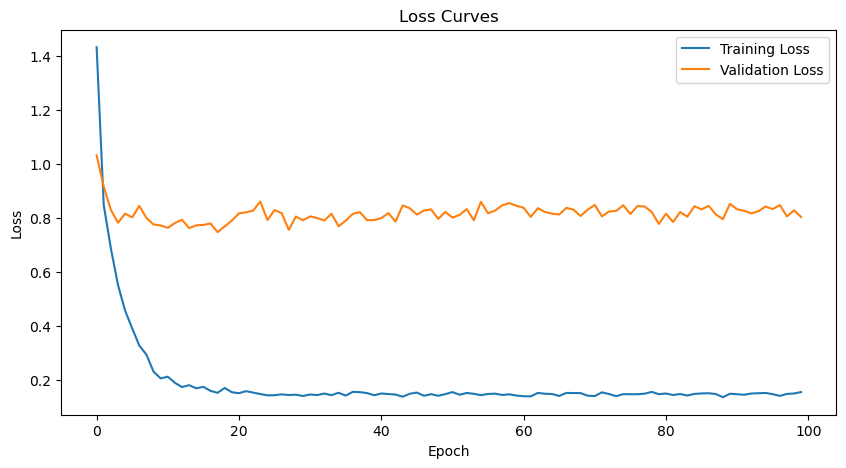

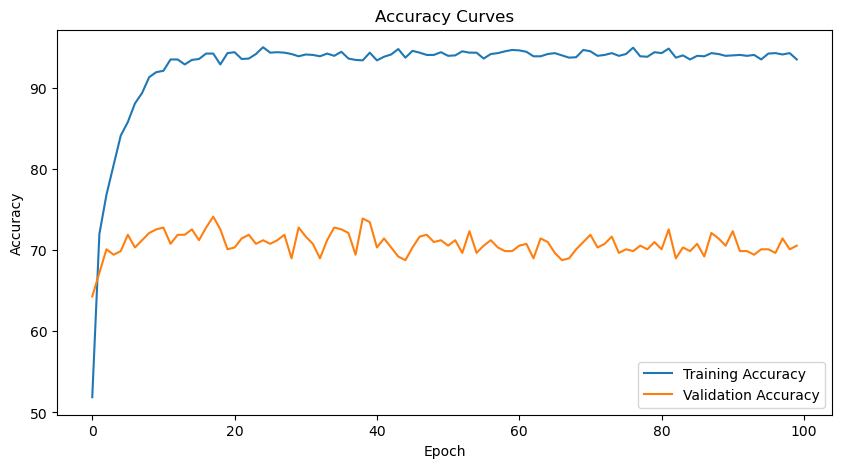

In [11]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

In [12]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize variables to track test loss and accuracy
test_loss = 0.0
correct = 0
total = 0

# Disable gradient computation for testing
with torch.no_grad():
    # Wrap test_loader with tqdm for a progress bar
    test_loop = tqdm(test_loader, desc="Testing ResNet", ncols=100)
    for images, labels in test_loop:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the ResNet model
        outputs = model(images)  # This will return logits directly for ResNet
        
        # Access the logits from the model's output object (ResNet outputs logits)
        logits = outputs  # For ResNet, we can directly use the output as logits

        # Compute loss
        loss = criterion(logits, labels)

        # Accumulate loss
        test_loss += loss.item() * images.size(0)  # Scale loss by batch size

        # Compute accuracy
        _, predicted = torch.max(logits.detach(), 1)  # Use .detach() instead of .data
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update the progress bar with loss and accuracy
        test_loop.set_postfix(loss=test_loss / total, accuracy=(correct / total) * 100)

# Compute final test loss and accuracy
test_loss /= total  # Normalize loss properly
test_accuracy = 100 * correct / total

# Print the results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")



Testing ResNet: 100%|███████████████████████| 4/4 [00:06<00:00,  1.56s/it, accuracy=56.8, loss=1.56]

Test Loss: 1.5618, Test Accuracy: 56.78%


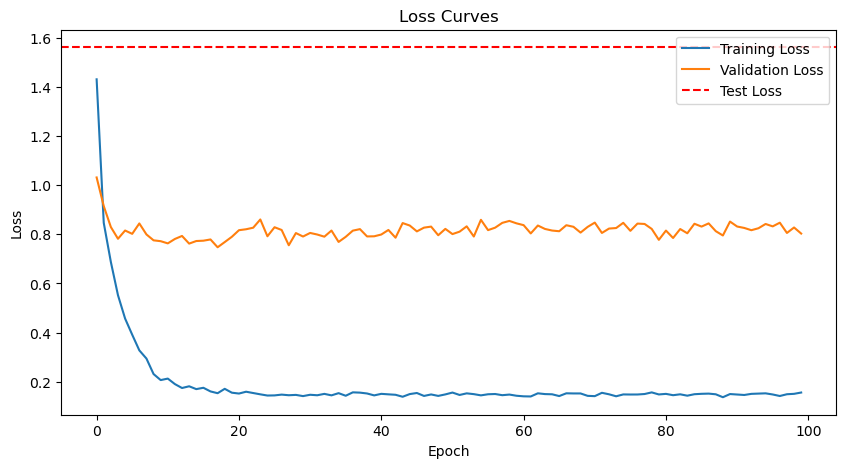

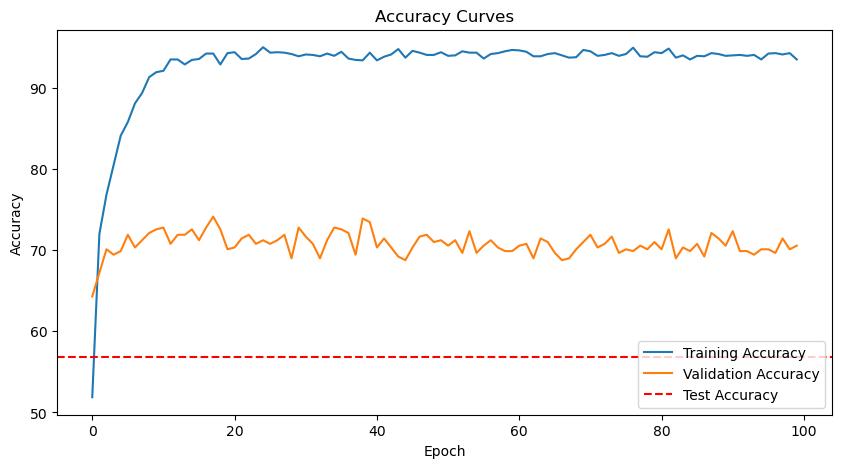

In [13]:
import matplotlib.pyplot as plt

# Plot training, validation, and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Add test loss as a horizontal line
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# Plot training, validation, and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')  # Add test accuracy as a horizontal line
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

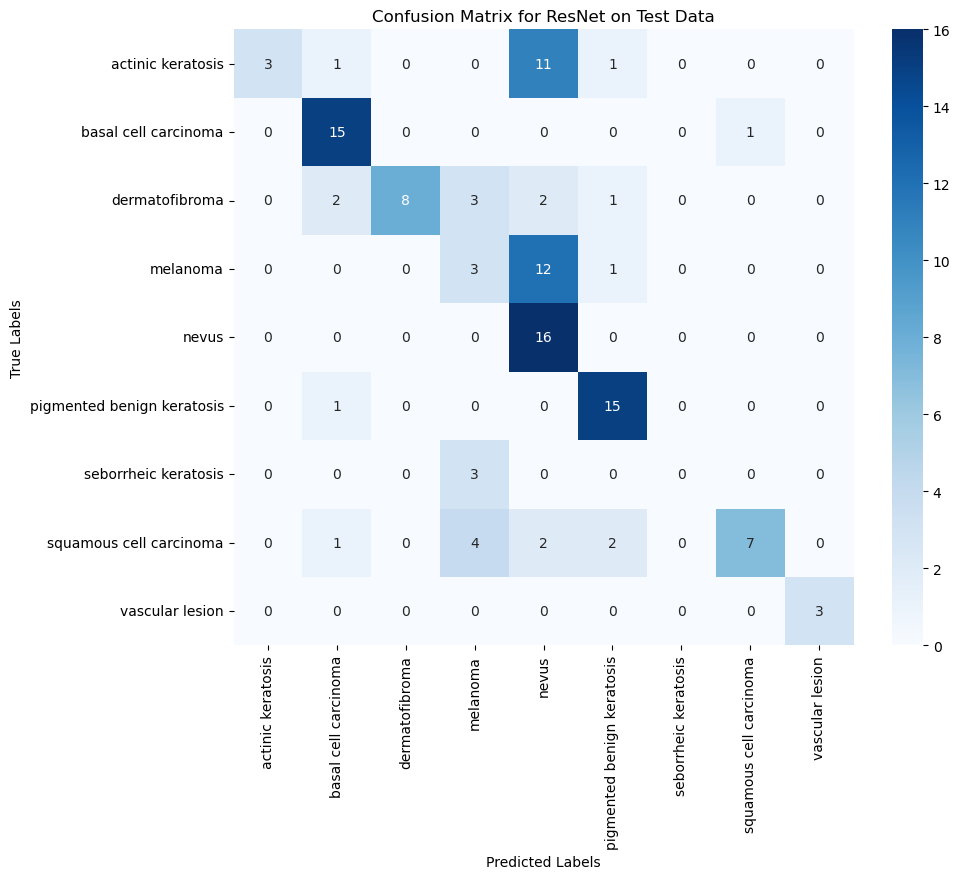

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in test_loader:  # Use test_loader for unseen data
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the ResNet model
        outputs = model(images)  # ResNet directly outputs logits
        
        # Extract logits
        logits = outputs

        # Get predicted class
        _, preds = torch.max(logits, 1)

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for ResNet on Test Data')
plt.show()



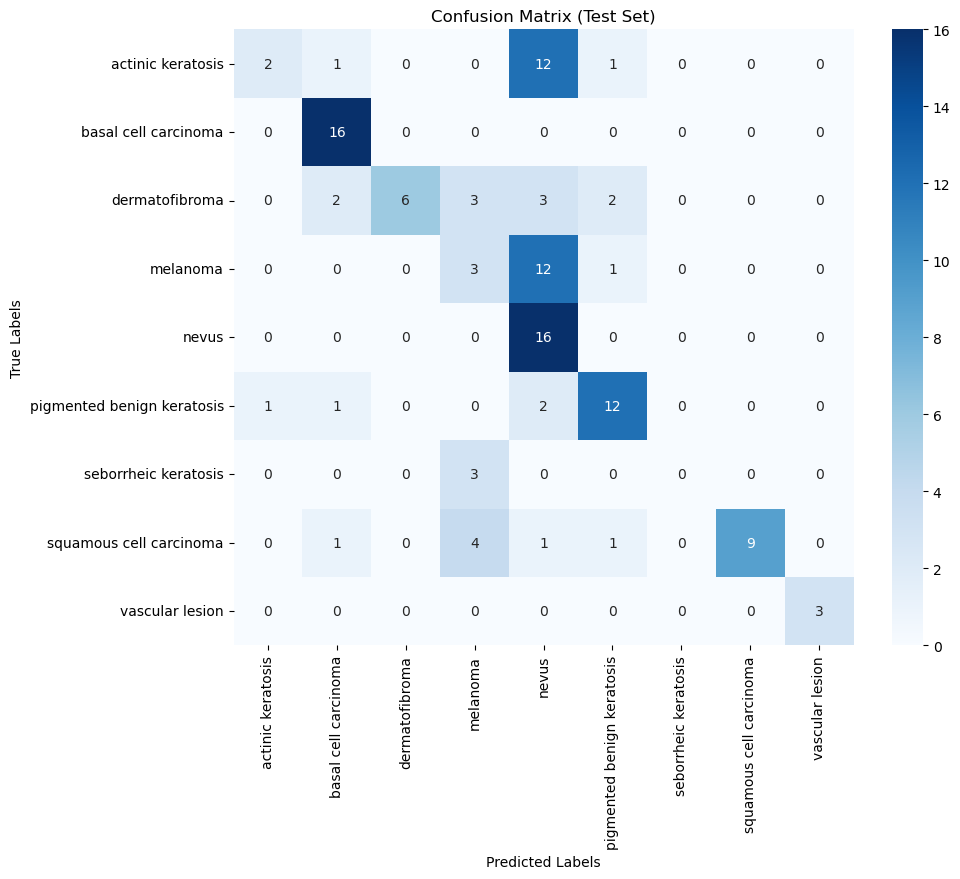

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels for test data
all_preds_test = []
all_labels_test = []

# Disable gradient computation for test set evaluation
with torch.no_grad():
    for images, labels in test_loader:  # Use test_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the ResNet model
        outputs = model(images)  # ResNet returns logits directly
        
        # Extract logits from the model's output object (ResNet's output is already logits)
        logits = outputs

        # Get predicted class
        _, preds = torch.max(logits, 1)

        # Store predictions and labels
        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

# Compute the confusion matrix for test data
cm_test = confusion_matrix(all_labels_test, all_preds_test)

# Check if test_dataset has class names
class_names = test_dataset.classes if hasattr(test_dataset, 'classes') else [str(i) for i in range(len(cm_test))]

# Plot the confusion matrix for test data
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Test Set)')
plt.show()



In [16]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels for training data
all_preds_train = []
all_labels_train = []

# Disable gradient computation for training set evaluation
with torch.no_grad():
    for images, labels in train_loader:  # Use train_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the ResNet model
        outputs = model(images)  # ResNet returns logits directly
        
        # Extract logits (For ResNet, logits are directly the output)
        logits = outputs  # No need to use .logits as with transformers

        # Get predicted class
        _, preds = torch.max(logits, 1)

        # Store predictions and labels
        all_preds_train.extend(preds.cpu().numpy())
        all_labels_train.extend(labels.cpu().numpy())

# Compute F1-score, precision, and recall for training set
f1_train = f1_score(all_labels_train, all_preds_train, average='weighted')  # Use 'macro' for equal class weighting
precision_train = precision_score(all_labels_train, all_preds_train, average='weighted')
recall_train = recall_score(all_labels_train, all_preds_train, average='weighted')

# Print the results
print(f"Training F1 Score: {f1_train:.3f}")
print(f"Training Precision: {precision_train:.4f}")
print(f"Training Recall: {recall_train:.4f}")



Training F1 Score: 0.948
Training Precision: 0.9491
Training Recall: 0.9514


In [17]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels for test data
all_preds_test = []
all_labels_test = []

# Disable gradient computation for test set evaluation
with torch.no_grad():
    for images, labels in test_loader:  # Use test_loader for evaluation
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the ResNet model
        outputs = model(images)  # ResNet directly returns logits
        
        # Extract logits (for ResNet, we can directly use the output as logits)
        logits = outputs

        # Get predicted class
        _, preds = torch.max(logits, 1)

        # Store predictions and labels
        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

# Compute F1-score, precision, and recall for the test set
f1_test = f1_score(all_labels_test, all_preds_test, average='weighted')  # Use 'macro' if you prefer equal class weighting
precision_test = precision_score(all_labels_test, all_preds_test, average='weighted')
recall_test = recall_score(all_labels_test, all_preds_test, average='weighted')

# Print the results
print(f"Test F1 Score: {f1_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall: {recall_test:.4f}")


Test F1 Score: 0.5374
Test Precision: 0.6289
Test Recall: 0.5678


C:\Users\Amir\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
